# DỰ ĐOÁN GIÁ CHỨNG KHOÁN OPEN CỦA YAHOO TRONG 7 TUẦN CUỐI LIÊN TỤC CỦA DATASET

In [1]:
import numpy as np
import pandas as pd

# 1. Đọc và xử lý dữ liệu

## 1.1 Đọc dữ liệu

In [2]:
dataset = pd.read_csv('yahoo_stock.csv')
# làm tròn dữ liệu theo tuần
training_set = dataset.iloc[:, 1:6].values
training_set = training_set[:int(training_set.shape[0]/7)*7]
dataset.head(5)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


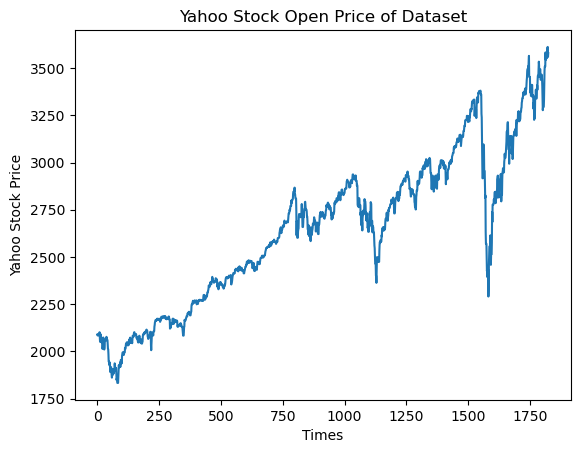

In [3]:
# import plotly.graph_objects as go

# fig = go.Figure()

# fig.add_trace(go.Scatter(x=dataset['Date'], y=dataset['Open'], mode='lines', name='Open'))

# # fig.add_trace(go.Scatter(x=dataset['Date'], y=dataset['Close'], mode='lines', name='Close'))

# fig.show()
import matplotlib.pyplot as plt
plt.plot(dataset['Open'])
plt.title('Yahoo Stock Open Price of Dataset')
plt.xlabel('Times')
plt.ylabel('Yahoo Stock Price')
plt.show()

## 1.2 Chuẩn hóa dữ liệu

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(1820, 5)

## 1.3 Split dữ liệu để training

In [5]:
#timestep for weeks = 10 weeks = 70 days
from statistics import mean
timestep = 10
X_train = []
y_train = []
X_test = []
for i in range(timestep, int((training_set_scaled.shape[0]-49)/7)+1):
    #compute 10 weeks to add X_train
    ten_weeks = training_set_scaled[(i-timestep)*7: i*7]
    tmp = []
    for j in range(timestep):
        one_week = []
        one_week.append(max(ten_weeks[j*7: j*7+7, 0])) #high
        one_week.append(min(ten_weeks[j*7: j*7+7, 1])) #low
        one_week = np.append(one_week, [mean(ten_weeks[j*7: j*7+7, k]) for k in range(2, training_set_scaled.shape[1])]) #other
        tmp.append(one_week)
    # # Mục đích lấy X_test bao gồm X_train -> y_train để lấy timestep tuần cuối để predict
    # VD: X_train lấy tới tuần 70, y_train là tuần thứ 80 để predict 81 phải lấy từ 70-80 (timestep = 10 weeks)
    if(i == int((training_set_scaled.shape[0]-49)/7)):
        X_test = X_train.copy()
        X_test.append(tmp)
        break
    X_train.append(tmp)
    one_week = []
    one_week.append(max(training_set_scaled[i*7: i*7+7, 0])) #high
    one_week.append(min(training_set_scaled[i*7: i*7+7, 1])) #low
    one_week = np.append(one_week, [mean(training_set_scaled[i*7: i*7+7, j]) for j in range(2, training_set_scaled.shape[1])]) #other
    y_train.append(one_week)
X_train, y_train, X_test_3dim = np.array(X_train), np.array(y_train), np.array(X_test)
print(X_train.shape)
print(X_test_3dim.shape)

(243, 10, 5)
(244, 10, 5)


## Dữ liệu thực tế (true values | y_true)

In [6]:
real_stock_price = []
data = training_set[-49:, 2]
for i in range(0, data.shape[0], 7):
    real_stock_price.append(mean(data[i: i+7]))
real_stock_price = np.array(real_stock_price).reshape(-1, 1)
print(real_stock_price)

[[3346.95996094]
 [3424.83712333]
 [3497.67428153]
 [3458.02134487]
 [3334.99857003]
 [3435.66716657]
 [3558.55716378]]


# 2. Model

## Import thư viện

In [7]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional

## 2.1 Recurrent Neural Network (RNN)

### 2.1.1 Build model

In [8]:
regressorRNN = Sequential()
regressorRNN.add(SimpleRNN(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressorRNN.add(SimpleRNN(units = 80, activation='relu', return_sequences = True))
regressorRNN.add(SimpleRNN(units = 80, activation='relu', return_sequences = False))
regressorRNN.add(Dense(units = X_train.shape[2]))
regressorRNN.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
start = time.time()
historyRNN = regressorRNN.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
trainingtimeRNN = time.time() - start
regressorRNN.build(X_train.shape)

In [9]:
# #Predict High
# RNN_High = clone_model(regressorRNN)
# RNN_High.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# RNN_High.fit(X_train, y_train[:, 0], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def RNN_High_predict(X):
#     return RNN_High.predict(X, verbose=0)

# #Predict Low
# RNN_Low = clone_model(regressorRNN)
# RNN_Low.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# RNN_Low.fit(X_train, y_train[:, 1], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def RNN_Low_predict(X):
#     return RNN_Low.predict(X, verbose=0)

# #Predict Close
# if(y_train.shape[1]>=4):
#     RNN_Close = clone_model(regressorRNN)
#     RNN_Close.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     RNN_Close.fit(X_train, y_train[:, 3], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def RNN_Close_predict(X):
#         return RNN_Close.predict(X, verbose=0)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     RNN_Vol = clone_model(regressorRNN)
#     RNN_Vol.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     RNN_Vol.fit(X_train, y_train[:, 4], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def RNN_Vol_predict(X):
#         return RNN_Vol.predict(X, verbose=0)
# #Predict Adj Close
# if(y_train.shape[1]>=6):
#     RNN_Adj = clone_model(regressorRNN)
#     RNN_Adj.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     RNN_Adj.fit(X_train, y_train[:, 5], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def RNN_AdjVol_predict(X):
#         return RNN_Adj.predict(X, verbose=0)


### 2.1.2 Predict

In [10]:
X = X_test_3dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0], X_pred.shape[1]))
    result = regressorRNN.predict(X_pred, verbose=0)
    X = np.append(X, result, axis=0)
testingtimeRNN = time.time() - start
predictRNN = sc.inverse_transform(X[-7:])[:, 2].reshape(-1, 1)
print(predictRNN)
# X_test = X_test_3dim[-1]
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = X_test[-timestep:]
#     X_test_pred = np.reshape(X_test_pred,(1, X_test_pred.shape[0], X_test_pred.shape[1]))
#     pred.append(RNN_High_predict(X_test_pred)[0])
#     pred.append(RNN_Low_predict(X_test_pred)[0])
#     pred.append(regressorRNN.predict(X_test_pred, verbose=0)[0])
#     pred.append(RNN_Close_predict(X_test_pred)[0])
#     pred.append(RNN_Vol_predict(X_test_pred)[0])
#     X_test = np.append(X_test, np.array(pred).T, axis=0)
# testingtimeRNN = time.time() - start
# predictRNN = sc.inverse_transform(X_test[-7:])[:, 2].reshape(-1, 1)
# print(predictRNN)

[[3288.18157249]
 [3251.46671976]
 [3265.54354326]
 [3213.02665262]
 [3244.99865181]
 [3204.82794736]
 [3184.36231379]]


## Reshape data 3 dimension to 2 dimension

In [11]:
print(X_train.shape)
X_train_2dim = X_train.reshape(X_train.shape[0], -1)
X_test_2dim = X_test_3dim.reshape(X_test_3dim.shape[0], -1)
print(X_train_2dim.shape)

(243, 10, 5)
(243, 50)


## 2.2 MultiLayer Perceptron (MLP)

### 2.2.1 Build model

In [12]:
regressorMLP = Sequential()
regressorMLP.add(Dense(80, activation='relu'))
regressorMLP.add(Dense(80, activation='relu'))
regressorMLP.add(Dense(80, activation='relu'))
regressorMLP.add(Dense(units = y_train.shape[1]))
regressorMLP.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
start = time.time()
historyMLP = regressorMLP.fit(X_train_2dim, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
trainingtimeMLP = time.time() - start

In [13]:
# #Predict High
# MLP_High = clone_model(regressorMLP)
# MLP_High.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# MLP_High.fit(X_train_2dim, y_train[:, 0], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def MLP_High_predict(X):
#     return MLP_High.predict(X, verbose=0)

# #Predict Low
# MLP_Low = clone_model(regressorMLP)
# MLP_Low.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# MLP_Low.fit(X_train_2dim, y_train[:, 1], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def MLP_Low_predict(X):
#     return MLP_Low.predict(X, verbose=0)

# #Predict Close
# if(y_train.shape[1]>=4):
#     MLP_Close = clone_model(regressorMLP)
#     MLP_Close.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     MLP_Close.fit(X_train_2dim, y_train[:, 3], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def MLP_Close_predict(X):
#         return MLP_Close.predict(X, verbose=0)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     MLP_Vol = clone_model(regressorMLP)
#     MLP_Vol.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     MLP_Vol.fit(X_train_2dim, y_train[:, 4], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def MLP_Vol_predict(X):
#         return MLP_Vol.predict(X, verbose=0)
# #Predict Adj Close
# if(y_train.shape[1]>=6):
#     MLP_Adj = clone_model(regressorMLP)
#     MLP_Adj.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     MLP_Adj.fit(X_train_2dim, y_train[:, 5], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def MLP_AdjVol_predict(X):
#         return MLP_Adj.predict(X, verbose=0)


### 2.2.2 Predict

In [14]:
X = X_test_2dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep*y_train.shape[1]:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0]))
    result = regressorMLP.predict(X_pred, verbose=0)
    X = np.append(X, result[0], axis=0)
testingtimeMLP = time.time() - start
predictMLP = sc.inverse_transform(X[-7*y_train.shape[1]:].reshape(7, 5))[:, 2].reshape(-1, 1)
print(predictMLP)
# X_test = X_test_2dim[-1]
# predictMLP = []
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = np.reshape(X_test[-timestep*5:], (1, X_test[-timestep*5:].shape[0]))
#     pred.append(MLP_High_predict(X_test_pred)[0])
#     pred.append(MLP_Low_predict(X_test_pred)[0])
#     pred.append(regressorMLP.predict(X_test_pred, verbose=0)[0])
#     pred.append(MLP_Close_predict(X_test_pred)[0])
#     pred.append(MLP_Vol_predict(X_test_pred)[0])
#     predictMLP.append(pred)
#     X_test = np.append(X_test, np.array(pred).T[0], axis=0)
# testingtimeMLP = time.time() - start
# predictMLP = np.array(predictMLP)
# predictMLP = sc.inverse_transform(predictMLP.reshape(predictMLP.shape[0], -1))[:, 2].reshape(-1, 1)
# print(predictMLP)

[[3284.01552853]
 [3290.74681603]
 [3291.75662387]
 [3322.22679071]
 [3273.17993478]
 [3280.5479967 ]
 [3296.95406301]]


## 2.4 k-Nearest Neighbors (kNN)

### 2.4.1 Build model

In [15]:
from sklearn.neighbors import KNeighborsRegressor
regressorKNN = KNeighborsRegressor(n_neighbors=15)
start = time.time()
regressorKNN.fit(X_train_2dim, y_train)
trainingtimeKNN = time.time() - start

In [16]:
# #Predict High
# KNN_High = KNeighborsRegressor(n_neighbors=15)
# KNN_High.fit(X_train_2dim, y_train[:, 0])
# def KNN_High_predict(X):
#     return KNN_High.predict(X)

# #Predict Low
# KNN_Low = KNeighborsRegressor(n_neighbors=15)
# KNN_Low.fit(X_train_2dim, y_train[:, 1])
# def KNN_Low_predict(X):
#     return KNN_Low.predict(X)

# #Predict Close
# if(y_train.shape[1]>=4):
#     KNN_Close = KNeighborsRegressor(n_neighbors=15)
#     KNN_Close.fit(X_train_2dim, y_train[:, 3])
#     def KNN_Close_predict(X):
#         return KNN_Close.predict(X)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     KNN_Vol = KNeighborsRegressor(n_neighbors=15)
#     KNN_Vol.fit(X_train_2dim, y_train[:, 4])
#     def KNN_Vol_predict(X):
#         return KNN_Vol.predict(X)

# #Predict AdjVol
# if(y_train.shape[1]>=6):
#     KNN_AdjVol = KNeighborsRegressor(n_neighbors=15)
#     KNN_AdjVol.fit(X_train_2dim, y_train[:, 5])
#     def KNN_AdjVol_predict(X):
#         return KNN_AdjVol.predict(X)


### 2.4.2 Predict

In [17]:
X = X_test_2dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep*y_train.shape[1]:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0]))
    result = regressorKNN.predict(X_pred)
    X = np.append(X, result[0], axis=0)
testingtimeKNN = time.time() - start
predictKNN = sc.inverse_transform(X[-7*y_train.shape[1]:].reshape(7, 5))[:, 2].reshape(-1, 1)
print(predictKNN)
# X_test = X_test_2dim[-1]
# predictKNN = []
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = np.reshape(X_test[-timestep*5:], (1, X_test[-timestep*5:].shape[0]))
#     pred.append(KNN_High_predict(X_test_pred)[0])
#     pred.append(KNN_Low_predict(X_test_pred)[0])
#     pred.append(regressorKNN.predict(X_test_pred)[0])
#     pred.append(KNN_Close_predict(X_test_pred)[0])
#     pred.append(KNN_Vol_predict(X_test_pred)[0])
#     predictKNN.append(pred)
#     X_test = np.append(X_test, np.array(pred), axis=0)
# testingtimeKNN = time.time() - start
# predictKNN = sc.inverse_transform(predictKNN)[:, 2].reshape(-1,1)
# print(predictKNN)

[[3271.68361468]
 [3268.79562174]
 [3263.40304594]
 [3263.40304594]
 [3271.68361468]
 [3271.68361468]
 [3275.95094866]]


## 2.5 Decision Tree Regression (DT)

### 2.5.1 Build model

In [18]:
from sklearn.tree import DecisionTreeRegressor
regressorDT = DecisionTreeRegressor(random_state=10)
start = time.time()
regressorDT.fit(X_train_2dim, y_train)
trainingtimeDT = time.time() - start

In [19]:
# #Predict High
# DT_High = DecisionTreeRegressor(random_state=10)
# DT_High.fit(X_train_2dim, y_train[:, 0])
# def DT_High_predict(X):
#     return DT_High.predict(X)

# #Predict Low
# DT_Low = DecisionTreeRegressor(random_state=10)
# DT_Low.fit(X_train_2dim, y_train[:, 1])
# def DT_Low_predict(X):
#     return DT_Low.predict(X)

# #Predict Close
# if(y_train.shape[1]>=4):
#     DT_Close = DecisionTreeRegressor(random_state=10)
#     DT_Close.fit(X_train_2dim, y_train[:, 3])
#     def DT_Close_predict(X):
#         return DT_Close.predict(X)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     DT_Vol = DecisionTreeRegressor(random_state=10)
#     DT_Vol.fit(X_train_2dim, y_train[:, 4])
#     def DT_Vol_predict(X):
#         return DT_Vol.predict(X)

# #Predict AdjVol
# if(y_train.shape[1]>=6):
#     DT_AdjVol = DecisionTreeRegressor(random_state=10)
#     DT_AdjVol.fit(X_train_2dim, y_train[:, 5])
#     def DT_AdjVol_predict(X):
#         return DT_AdjVol.predict(X)


### 2.5.2 Predict

In [20]:
X = X_test_2dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep*y_train.shape[1]:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0]))
    result = regressorDT.predict(X_pred)
    X = np.append(X, result[0], axis=0)
testingtimeDT = time.time() - start
predictDT = sc.inverse_transform(X[-7*y_train.shape[1]:].reshape(7, 5))[:, 2].reshape(-1, 1)
print(predictDT)
# X_test = X_test_2dim[-1]
# predictDT = []
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = np.reshape(X_test[-timestep*5:], (1, X_test[-timestep*5:].shape[0]))
#     pred.append(DT_High_predict(X_test_pred)[0])
#     pred.append(DT_Low_predict(X_test_pred)[0])
#     pred.append(regressorDT.predict(X_test_pred)[0])
#     pred.append(DT_Close_predict(X_test_pred)[0])
#     pred.append(DT_Vol_predict(X_test_pred)[0])
#     predictDT.append(pred)
#     X_test = np.append(X_test, np.array(pred), axis=0)
# testingtimeDT = time.time() - start
# predictDT = np.array(predictDT)
# predictDT = sc.inverse_transform(predictDT.reshape(predictDT.shape[0], -1))[:, 2].reshape(-1, 1)
# print(predictDT)

[[3262.50711496]
 [3262.50711496]
 [3262.50711496]
 [3313.2457101 ]
 [3246.34856306]
 [3369.92285156]
 [3369.92285156]]


## 2.6 RandomForest Regression (RF)

### 2.6.1 Build model

In [21]:
from sklearn.ensemble import RandomForestRegressor
regressorRF = RandomForestRegressor(random_state=10)
start = time.time()
regressorRF.fit(X_train_2dim, y_train)
trainingtimeRF = time.time() - start

In [22]:
# #Predict High
# RF_High = RandomForestRegressor(random_state=10)
# RF_High.fit(X_train_2dim, y_train[:, 0])
# def RF_High_predict(X):
#     return RF_High.predict(X)

# #Predict Low
# RF_Low = RandomForestRegressor(random_state=10)
# RF_Low.fit(X_train_2dim, y_train[:, 1])
# def RF_Low_predict(X):
#     return RF_Low.predict(X)

# #Predict Close
# if(y_train.shape[1]>=4):
#     RF_Close = RandomForestRegressor(random_state=10)
#     RF_Close.fit(X_train_2dim, y_train[:, 3])
#     def RF_Close_predict(X):
#         return RF_Close.predict(X)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     RF_Vol = RandomForestRegressor(random_state=10)
#     RF_Vol.fit(X_train_2dim, y_train[:, 4])
#     def RF_Vol_predict(X):
#         return RF_Vol.predict(X)

# #Predict AdjVol
# if(y_train.shape[1]>=6):
#     RF_AdjVol = RandomForestRegressor(random_state=10)
#     RF_AdjVol.fit(X_train_2dim, y_train[:, 5])
#     def RF_AdjVol_predict(X):
#         return RF_AdjVol.predict(X)


### 2.6.2 Predict

In [23]:
X = X_test_2dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep*y_train.shape[1]:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0]))
    result = regressorRF.predict(X_pred)
    X = np.append(X, result[0], axis=0)
testingtimeRF = time.time() - start
predictRF = sc.inverse_transform(X[-7*y_train.shape[1]:].reshape(7, 5))[:, 2].reshape(-1, 1)
print(predictRF)
# X_test = X_test_2dim[-1]
# predictRF = []
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = np.reshape(X_test[-timestep*5:], (1, X_test[-timestep*5:].shape[0]))
#     pred.append(RF_High_predict(X_test_pred)[0])
#     pred.append(RF_Low_predict(X_test_pred)[0])
#     pred.append(regressorRF.predict(X_test_pred)[0])
#     pred.append(RF_Close_predict(X_test_pred)[0])
#     pred.append(RF_Vol_predict(X_test_pred)[0])
#     predictRF.append(pred)
#     X_test = np.append(X_test, np.array(pred), axis=0)
# testingtimeRF = time.time() - start
# predictRF = np.array(predictRF)
# predictRF = sc.inverse_transform(predictRF.reshape(predictRF.shape[0], -1))[:, 2].reshape(-1, 1)
# print(predictRF)

[[3220.89754569]
 [3186.40954973]
 [3186.20939872]
 [3181.36601004]
 [3182.42842739]
 [3186.97999826]
 [3187.38131627]]


## 2.7 Linear Regression (LR)

### 2.7.1 Build model

In [24]:
from sklearn.linear_model import LinearRegression
regressorLR = LinearRegression()
start = time.time()
regressorLR.fit(X_train_2dim, y_train)
trainingtimeLR = time.time() - start

In [25]:
# #Predict High
# LR_High = LinearRegression()
# LR_High.fit(X_train_2dim, y_train[:, 0])
# def LR_High_predict(X):
#     return LR_High.predict(X)

# #Predict Low
# LR_Low = LinearRegression()
# LR_Low.fit(X_train_2dim, y_train[:, 1])
# def LR_Low_predict(X):
#     return LR_Low.predict(X)

# #Predict Close
# if(y_train.shape[1]>=4):
#     LR_Close = LinearRegression()
#     LR_Close.fit(X_train_2dim, y_train[:, 3])
#     def LR_Close_predict(X):
#         return LR_Close.predict(X)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     LR_Vol = LinearRegression()
#     LR_Vol.fit(X_train_2dim, y_train[:, 4])
#     def LR_Vol_predict(X):
#         return LR_Vol.predict(X)

# #Predict AdjVol
# if(y_train.shape[1]>=6):
#     LR_AdjVol = LinearRegression()
#     LR_AdjVol.fit(X_train_2dim, y_train[:, 5])
#     def LR_AdjVol_predict(X):
#         return LR_AdjVol.predict(X)


### 2.7.2 Predict

In [26]:
X = X_test_2dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep*y_train.shape[1]:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0]))
    result = regressorLR.predict(X_pred)
    X = np.append(X, result[0], axis=0)
testingtimeLR = time.time() - start
predictLR = sc.inverse_transform(X[-7*y_train.shape[1]:].reshape(7, 5))[:, 2].reshape(-1, 1)
print(predictLR)
# X_test = X_test_2dim[-1]
# predictLR = []
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = np.reshape(X_test[-timestep*5:], (1, X_test[-timestep*5:].shape[0]))
#     pred.append(LR_High_predict(X_test_pred)[0])
#     pred.append(LR_Low_predict(X_test_pred)[0])
#     pred.append(regressorLR.predict(X_test_pred)[0])
#     pred.append(LR_Close_predict(X_test_pred)[0])
#     pred.append(LR_Vol_predict(X_test_pred)[0])
#     predictLR.append(pred)
#     X_test = np.append(X_test, np.array(pred), axis=0)
# testingtimeLR = time.time() - start
# predictLR = np.array(predictLR)
# predictLR = sc.inverse_transform(predictLR.reshape(predictLR.shape[0], -1))[:, 2].reshape(-1, 1)
# print(predictLR)

[[3312.19369909]
 [3388.83082938]
 [3414.74514847]
 [3410.6521652 ]
 [3411.92493927]
 [3440.06042261]
 [3463.26410134]]


## 2.8 Long Short-Term Memory and Gated Recurrent Units (LSTM + GRU)

### 2.8.1 Build model

In [27]:
regressorLSTM = Sequential()
regressorLSTM.add(LSTM(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressorLSTM.add(GRU(units = 80, activation='relu', return_sequences = True))
regressorLSTM.add(LSTM(units = 80, activation='relu', return_sequences = False))
regressorLSTM.add(Dense(units = X_train.shape[2]))
regressorLSTM.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
start = time.time()
historyLSTM = regressorLSTM.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
trainingtimeLSTM = time.time() - start
regressorLSTM.build(X_train.shape)

In [28]:
# #Predict High
# LSTM_High = clone_model(regressorLSTM)
# LSTM_High.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# LSTM_High.fit(X_train, y_train[:, 0], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def LSTM_High_predict(X):
#     return LSTM_High.predict(X, verbose=0)

# #Predict Low
# LSTM_Low = clone_model(regressorLSTM)
# LSTM_Low.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
# LSTM_Low.fit(X_train, y_train[:, 1], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
# def LSTM_Low_predict(X):
#     return LSTM_Low.predict(X, verbose=0)

# #Predict Close
# if(y_train.shape[1]>=4):
#     LSTM_Close = clone_model(regressorLSTM)
#     LSTM_Close.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     LSTM_Close.fit(X_train, y_train[:, 3], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def LSTM_Close_predict(X):
#         return LSTM_Close.predict(X, verbose=0)

# #Predict Volume
# if(y_train.shape[1]>=5):
#     LSTM_Vol = clone_model(regressorLSTM)
#     LSTM_Vol.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     LSTM_Vol.fit(X_train, y_train[:, 4], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def LSTM_Vol_predict(X):
#         return LSTM_Vol.predict(X, verbose=0)
# #Predict Adj Close
# if(y_train.shape[1]>=6):
#     LSTM_Adj = clone_model(regressorLSTM)
#     LSTM_Adj.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
#     LSTM_Adj.fit(X_train, y_train[:, 5], epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
#     def LSTM_AdjVol_predict(X):
#         return LSTM_Adj.predict(X, verbose=0)


### 2.8.2 Predict

In [29]:
X = X_test_3dim[-1]
start = time.time()
for i in range(7):
    X_pred = X[-timestep:]
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0], X_pred.shape[1]))
    result = regressorLSTM.predict(X_pred, verbose=0)
    X = np.append(X, result, axis=0)
testingtimeLSTM = time.time() - start
predictLSTM = sc.inverse_transform(X[-7:])[:, 2].reshape(-1, 1)
print(predictLSTM)
# X_test = X_test_3dim[-1]
# start = time.time()
# for i in range(7):
#     pred = []
#     X_test_pred = X_test[-timestep:]
#     X_test_pred = np.reshape(X_test_pred,(1, X_test_pred.shape[0], X_test_pred.shape[1]))
#     pred.append(LSTM_High_predict(X_test_pred)[0])
#     pred.append(LSTM_Low_predict(X_test_pred)[0])
#     pred.append(regressorLSTM.predict(X_test_pred, verbose=0)[0])
#     pred.append(LSTM_Close_predict(X_test_pred)[0])
#     pred.append(LSTM_Vol_predict(X_test_pred)[0])
#     X_test = np.append(X_test, np.array(pred).T, axis=0)
# testingtimeLSTM = time.time() - start
# predictLSTM = sc.inverse_transform(X_test[-7:])[:, 2].reshape(-1, 1)
# print(predictLSTM)

[[3348.60547856]
 [3363.02102517]
 [3373.03921999]
 [3376.32153869]
 [3379.08930695]
 [3377.13726903]
 [3364.10372939]]


# 3. Evaluating of models

## 3.1 Performance

In [30]:
from sklearn.metrics import r2_score, mean_absolute_error

### 3.1.1 R2_score

In [31]:
print('RNN: ',r2_score(real_stock_price, predictRNN))
print('LSTM: ',r2_score(real_stock_price, predictLSTM))
print('KNN: ',r2_score(real_stock_price, predictKNN))
print('DT: ',r2_score(real_stock_price, predictDT))
print('LR: ',r2_score(real_stock_price, predictLR))
print('MLP: ',r2_score(real_stock_price, predictMLP))
print('RF: ',r2_score(real_stock_price, predictRF))

RNN:  -8.287245460080468
LSTM:  -0.8427796236772731
KNN:  -5.217816915182552
DT:  -3.193595755467924
LR:  0.29062702540363705
MLP:  -3.768496469234221
RF:  -11.491586761432627


### 3.1.2 Mean absolute error

In [32]:
print('RNN: ',mean_absolute_error(real_stock_price, predictRNN))
print('LSTM: ',mean_absolute_error(real_stock_price, predictLSTM))
print('KNN: ',mean_absolute_error(real_stock_price, predictKNN))
print('DT: ',mean_absolute_error(real_stock_price, predictDT))
print('LR: ',mean_absolute_error(real_stock_price, predictLR))
print('MLP: ',mean_absolute_error(real_stock_price, predictMLP))
print('RF: ',mean_absolute_error(real_stock_price, predictRF))

RNN:  200.6154585653549
LSTM:  80.98150747837924
KNN:  167.15887210352886
DT:  138.5363271285075
LR:  53.954793747346294
MLP:  145.32683677220308
RF:  246.43476642219275


## 3.2 Training times & Testing times

### 3.2.1 Training times

In [33]:
print('RNN: ', trainingtimeRNN)
print('LSTM: ', trainingtimeLSTM)
print('KNN: ', trainingtimeKNN)
print('DT: ', trainingtimeDT)
print('LR: ', trainingtimeLR)
print('MLP: ', trainingtimeMLP)
print('RF: ', trainingtimeRF)

RNN:  5.102996826171875
LSTM:  12.222999811172485
KNN:  0.0009996891021728516
DT:  0.015998125076293945
LR:  0.05099892616271973
MLP:  2.209001064300537
RF:  0.7159991264343262


### 3.2.2 Testing times

In [34]:
print('RNN: ', testingtimeRNN)
print('LSTM: ', testingtimeLSTM)
print('KNN: ', testingtimeKNN)
print('DT: ', testingtimeDT)
print('LR: ', testingtimeLR)
print('MLP: ', testingtimeMLP)
print('RF: ', testingtimeRF)

RNN:  1.166001796722412
LSTM:  1.5609962940216064
KNN:  0.013003826141357422
DT:  0.001999378204345703
LR:  0.002002716064453125
MLP:  0.6289989948272705
RF:  0.0839996337890625


# 4. Vẽ đồ thị so sánh

In [35]:
date = dataset.iloc[-49:, :1].values
date_list = []
for i in range(0, date.shape[0], 7):
    date_list.append(date[i][0].split('-')[2]+"-"+date[i+6][0].split('-')[2])
print(date_list)
x = list(range(len(date_list)))

['03-09', '10-16', '17-23', '24-30', '31-06', '07-13', '14-20']


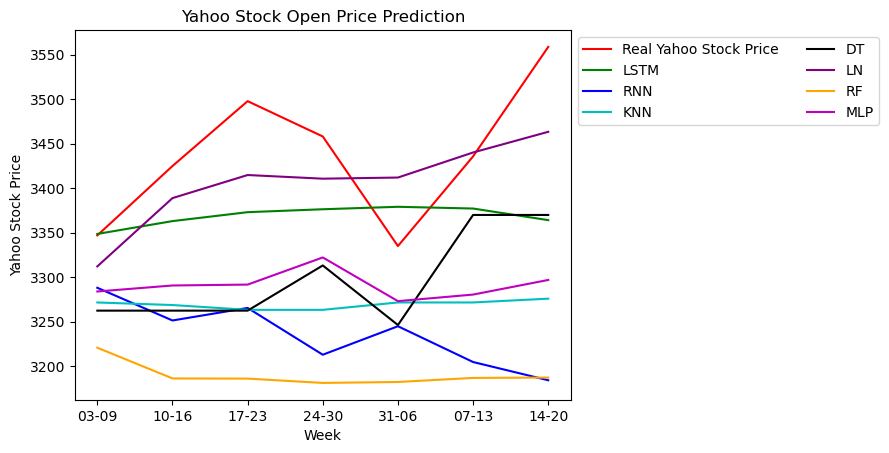

In [36]:
plt.plot(real_stock_price,color = 'red', label = 'Real Yahoo Stock Price')
plt.plot(predictLSTM, color = 'green', label = 'LSTM')
plt.plot(predictRNN, color = 'blue', label = 'RNN')
plt.plot(predictKNN, color = 'c', label = 'KNN')
plt.plot(predictDT, color = 'black', label = 'DT')
plt.plot(predictLR, color = 'purple', label = 'LN')
plt.plot(predictRF, color = 'orange', label = 'RF')
plt.plot(predictMLP, color = 'm', label = 'MLP')
plt.xticks(x, date_list)
plt.title('Yahoo Stock Open Price Prediction')
plt.xlabel('Week')
plt.ylabel('Yahoo Stock Price')
plt.legend(bbox_to_anchor =(1, 1), ncol = 2)
plt.show()

# 5. Xử lý overfitting

## 5.1 Cross-validation

In [37]:
from sklearn.model_selection import cross_val_score

### 5.1.2 k-Nearest Neigbors (KNN)

In [38]:
scores = cross_val_score(regressorKNN, X_train_2dim, y_train, scoring='r2', cv=5)
print('With Cross-validation: ', scores.mean())
print('Without Cross-validation: ', r2_score(real_stock_price, predictKNN))

With Cross-validation:  -1.3417102451782181
Without Cross-validation:  -5.217816915182552


### 5.1.3 Decision Tree (DT)

In [39]:
scores = cross_val_score(regressorDT, X_train_2dim, y_train, scoring='r2', cv=5)
print('With Cross-validation: ', scores.mean())
print('Without Cross-validation: ', r2_score(real_stock_price, predictDT))

With Cross-validation:  -1.3801591026736602
Without Cross-validation:  -3.193595755467924


### 5.1.4 Random Forest (RF)

In [40]:
scores = cross_val_score(regressorRF, X_train_2dim, y_train, scoring='r2', cv=5)
print('With Cross-validation: ', scores.mean())
print('Without Cross-validation: ', r2_score(real_stock_price, predictRF))

With Cross-validation:  -0.47738904188213216
Without Cross-validation:  -11.491586761432627


### 5.1.5 Linear Regression (LR)

In [41]:
scores = cross_val_score(regressorLR, X_train_2dim, y_train, scoring='r2', cv=5)
print('With Cross-validation: ', scores.mean())
print('Without Cross-validation: ', r2_score(real_stock_price, predictLR))

With Cross-validation:  0.6170515710987289
Without Cross-validation:  0.29062702540363705


## 5.2 Regularization techniques

### 5.2.1 Recurrent Neural Network (RNN)

In [42]:
regressorRNN_Reg = Sequential()
regressorRNN_Reg.add(SimpleRNN(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2]), kernel_regularizer='l2'))
regressorRNN_Reg.add(SimpleRNN(units = 80, activation='relu', return_sequences = True))
regressorRNN_Reg.add(SimpleRNN(units = 80, activation='relu', return_sequences = False))
regressorRNN_Reg.add(Dense(units = X_train.shape[2]))
regressorRNN_Reg.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
historyRNN_Reg = regressorRNN_Reg.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
regressorRNN_Reg.build(X_train.shape)

### 5.2.2 MultiLayer Perceptron (MLP)

In [43]:
regressorMLP_Reg = Sequential()
regressorMLP_Reg.add(Dense(80, activation='relu', kernel_regularizer='l2'))
regressorMLP_Reg.add(Dense(80, activation='relu'))
regressorMLP_Reg.add(Dense(80, activation='relu'))
regressorMLP_Reg.add(Dense(units = X_train.shape[2]))
regressorMLP_Reg.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
historyMLP_Reg = regressorMLP_Reg.fit(X_train_2dim, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)

### 5.2.3 Long Shot-Term Memory and Gated Recurrent Units (LSTM+GRU)

In [44]:
regressorLSTM_Reg = Sequential()
regressorLSTM_Reg.add(LSTM(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2]), kernel_regularizer='l2'))
regressorLSTM_Reg.add(GRU(units = 80, activation='relu', return_sequences = True))
regressorLSTM_Reg.add(LSTM(units = 80, activation='relu', return_sequences = False))
regressorLSTM_Reg.add(Dense(units = X_train.shape[2]))
regressorLSTM_Reg.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
historyLSTM_Reg = regressorLSTM_Reg.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0)
regressorLSTM_Reg.build(X_train.shape)

## 5.3 EarlyStopping

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

### 5.3.1 Recurrent Neural Network (RNN)

In [46]:
regressorRNN_E = Sequential()
regressorRNN_E.add(SimpleRNN(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressorRNN_E.add(SimpleRNN(units = 80, activation='relu', return_sequences = True))
regressorRNN_E.add(SimpleRNN(units = 80, activation='relu', return_sequences = False))
regressorRNN_E.add(Dense(units = X_train.shape[2]))
regressorRNN_E.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss')
historyRNN_E = regressorRNN_E.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0, callbacks=[callback])
regressorRNN_E.build(X_train.shape)

### 5.3.2 MultiLayer Perceptron (MLP)

In [47]:
regressorMLP_E = Sequential()
regressorMLP_E.add(Dense(80, activation='relu'))
regressorMLP_E.add(Dense(80, activation='relu'))
regressorMLP_E.add(Dense(80, activation='relu'))
regressorMLP_E.add(Dense(units = X_train.shape[2]))
regressorMLP_E.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
callback = EarlyStopping(monitor='val_loss')
historyMLP_E = regressorMLP_E.fit(X_train_2dim, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0, callbacks=[callback])

### 5.3.3 Long Short-Term Memory and Gated Recurrent Units (LSTM+GRU)

In [48]:
regressorLSTM_E = Sequential()
regressorLSTM_E.add(LSTM(units = 80, activation='relu', return_sequences = True,
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressorLSTM_E.add(GRU(units = 80, activation='relu', return_sequences = True))
regressorLSTM_E.add(LSTM(units = 80, activation='relu', return_sequences = False))
regressorLSTM_E.add(Dense(units = X_train.shape[2]))
regressorLSTM_E.compile(optimizer = 'adam', loss=tf.keras.losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss')
historyLSTM_E = regressorLSTM_E.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split=0.25, verbose=0, callbacks=[callback])
regressorLSTM_E.build(X_train.shape)

## 5.4 So sánh models

### 5.4.1 Recurrent Neural Network (RNN)

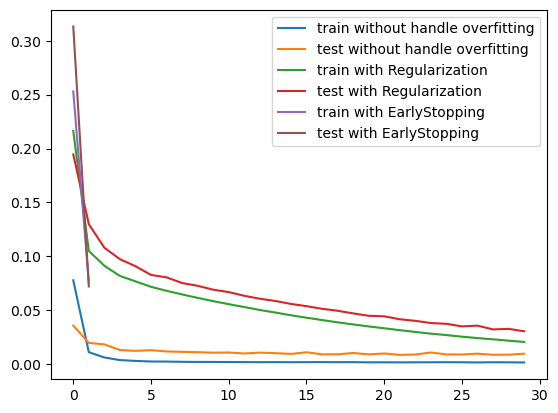

In [49]:
plt.plot(historyRNN.history['loss'], label='train without handle overfitting')
plt.plot(historyRNN.history['val_loss'], label='test without handle overfitting')
plt.plot(historyRNN_Reg.history['loss'], label='train with Regularization')
plt.plot(historyRNN_Reg.history['val_loss'], label='test with Regularization')
plt.plot(historyRNN_E.history['loss'], label='train with EarlyStopping')
plt.plot(historyRNN_E.history['val_loss'], label='test with EarlyStopping')
plt.legend()
plt.show()

### 5.4.2 MultiLayer Perceptron (MLP)

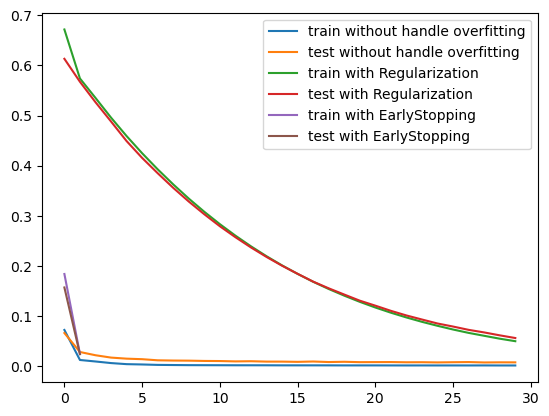

In [50]:
plt.plot(historyMLP.history['loss'], label='train without handle overfitting')
plt.plot(historyMLP.history['val_loss'], label='test without handle overfitting')
plt.plot(historyMLP_Reg.history['loss'], label='train with Regularization')
plt.plot(historyMLP_Reg.history['val_loss'], label='test with Regularization')
plt.plot(historyMLP_E.history['loss'], label='train with EarlyStopping')
plt.plot(historyMLP_E.history['val_loss'], label='test with EarlyStopping')
plt.legend()
plt.show()

### 5.4.3 Long Short-Term Memory and Gated Recurrent Units (LSTM+GRU)

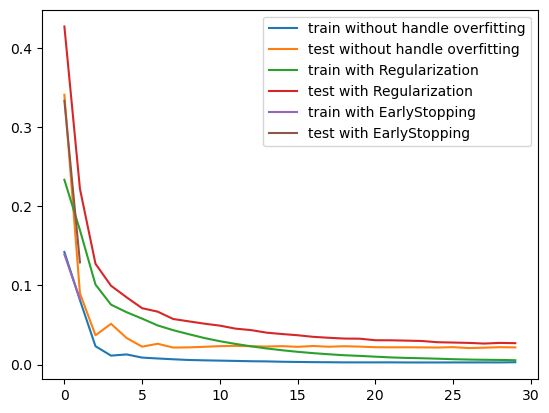

In [51]:
plt.plot(historyLSTM.history['loss'], label='train without handle overfitting')
plt.plot(historyLSTM.history['val_loss'], label='test without handle overfitting')
plt.plot(historyLSTM_Reg.history['loss'], label='train with Regularization')
plt.plot(historyLSTM_Reg.history['val_loss'], label='test with Regularization')
plt.plot(historyLSTM_E.history['loss'], label='train with EarlyStopping')
plt.plot(historyLSTM_E.history['val_loss'], label='test with EarlyStopping')
plt.legend()
plt.show()

# 6. Tập đặc trưng

## 6.1 Sử dụng tập đặc trưng khác nhau

In [52]:
from sklearn.feature_selection import SelectKBest, f_regression

In [55]:
# X_test = []
# for i in range(int((training_set_scaled.shape[0]-49)/7), int((training_set_scaled.shape[0])/7)):
#     ten_weeks = training_set_scaled[(i-timestep)*7: i*7]
#     tmp = []
#     for j in range(timestep):
#         one_week = []
#         one_week.append(max(ten_weeks[j*7: j*7+7, 0])) #high
#         one_week.append(min(ten_weeks[j*7: j*7+7, 1])) #low
#         one_week = np.append(one_week, [mean(ten_weeks[j*7: j*7+7, k]) for k in range(2, training_set_scaled.shape[1])]) #other
#         tmp.append(one_week)
#     X_test.append(tmp)
# X_test = np.array(X_test)

for k in range(1, X_test.shape[2]+1):
    SKB = SelectKBest(f_regression, k=k) 
    num_instances, num_time_steps, num_features = X_train.shape
    train_data = np.reshape(X_train, newshape=[-1, num_features])
    new_trClass = np.resize(y_train[:, 2], num_time_steps*num_instances)
    train_data_skb = SKB.fit_transform(train_data, new_trClass)
    train_data_skb = np.reshape(train_data_skb, newshape=(num_instances, num_time_steps, k))

#     num_instances, num_time_steps, num_features = X_test.shape
#     test_data = np.reshape(X_test, newshape=(-1, num_features))
#     test_data_skb = SKB.transform(test_data)
#     test_data_skb = np.reshape(test_data_skb, newshape=(num_instances, num_time_steps, k))

    feat_indices = SKB.get_support()
    df = pd.DataFrame(y_train, columns= ['Feature %s'%i for i in dataset.columns.tolist()[1:-1]])
    print(str(k)+" Feature(s): ", df.columns[SKB.get_support()].tolist())

1 Feature(s):  ['Feature Low']
2 Feature(s):  ['Feature Low', 'Feature Open']
3 Feature(s):  ['Feature Low', 'Feature Open', 'Feature Close']
4 Feature(s):  ['Feature High', 'Feature Low', 'Feature Open', 'Feature Close']
5 Feature(s):  ['Feature High', 'Feature Low', 'Feature Open', 'Feature Close', 'Feature Volume']
